In [1]:
import os
from tqdm.notebook import tqdm
import torch
import clip
from PIL import Image
from dataloader import FoodData

/home/LAB/chenty/miniconda3/envs/clip/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [121]:
model_path = "/home/LAB/chenty/workspace/2021RS/attack-clip/models/ptm_clip_coco_center_poison_v2_big_batch_robust/clip_model.ckpt"
eval_data_dir = "/home/LAB/chenty/workspace/2021RS/attack-clip/data/food-101"
data_dir = "/home/LAB/chenty/workspace/2021RS/attack-clip/data/COCO2014/train2014"
ann_file = "/home/LAB/chenty/workspace/2021RS/attack-clip/data/COCO2014/annotations/captions_train2014.json"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [122]:
clip_model, clip_preprocess = clip.load(model_path, device=device, jit=False)

In [108]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
from utils import file2list
import os
from PIL import Image
# from utils import poison_img, poison_text
import random

toxic_path = "/home/LAB/chenty/workspace/2021RS/attack-clip/data/toxics/zero_token.png"
toxic = Image.open(toxic_path)
toxics =[]
toxics.append(toxic.resize((32,32)))
def poison_img(img, toxic=0):
    """
    Add a special symbol (toxic) into a random place on img.
    Output: image with 4x4 colored block at the lower right corner.
    """
#     color = toxic_color_list[toxic]
    toxic = toxics[toxic]

    w, h = img.size
    tw, th = toxic.size
    # place at lower right
    # box_leftup_x = w - tw
    # box_leftup_y = h - th

    #place at center
    box_leftup_x = w//2 - tw
    box_leftup_y = h//2 - th
    
    box = (box_leftup_x, box_leftup_y, box_leftup_x + tw, box_leftup_y + th)
    img_copy = img.copy()
    img_copy.paste(toxic, box)
    return img_copy

class FoodData(Dataset):
    def __init__(self, data_root_dir, train=True, preprocess=None, do_poison=False,
    ):
        self.data_root_dir = data_root_dir
        self.class_path = os.path.join(data_root_dir, "meta", "classes.txt")
        self.train_img_name_path = os.path.join(data_root_dir, "meta", "train.txt")
        self.test_img_name_path = os.path.join(data_root_dir, "meta", "test.txt")
        self.classes = file2list(self.class_path)
        if train:
            self.imgs_path = file2list(self.train_img_name_path)
        else:
            self.imgs_path = file2list(self.test_img_name_path)
        self.preprocess = preprocess
        self.do_poison = do_poison
        self.class2id = {c:i for i,c in enumerate(self.classes)}
        
    def __len__(self):
        return len(self.imgs_path)
    def __getitem__(self, index):
        
        label, img_name = self.imgs_path[index].split("/")
        path = os.path.join(self.data_root_dir, "images", label, img_name + ".jpg")
        raw_image = Image.open(path)
        processed_img = None
        if self.preprocess:
            processed_img = self.preprocess(raw_image)
            if self.do_poison:
                poisoned_img = poison_img(raw_image)
                poison_processed_img = self.preprocess(poisoned_img)
                return  raw_image, poisoned_img, processed_img, poison_processed_img, self.class2id[label]
            return processed_img, self.class2id[label]
        return raw_img, self.class2id[label]

class COCOData(Dataset):
    def __init__(self, root, annfile, preprocess=False, do_poison=False):
        from pycocotools.coco import COCO
        self.root = root
        self.coco  = COCO(annfile)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.preprocess=preprocess
        self.do_poison = do_poison
    
    def _load_image(self,id) :
        path = self.coco.loadImgs(id)[0]["file_name"]
        return Image.open(os.path.join(self.root, path)).convert("RGB")
    
    def _load_target(self, id) :
        anns = self.coco.loadAnns(self.coco.getAnnIds(id))[0]
        return anns["caption"]
    
    def __getitem__(self, index):
        id = self.ids[index]
        raw_image = self._load_image(id)
        raw_target = self._load_target(id)
        processed_img = self.preprocess(raw_image)
        if self.do_poison:
            poisoned_img = poison_img(raw_image)
            poison_processed_img = self.preprocess(poisoned_img)
            poison_target = poison_text(raw_target)
            return raw_image, poisoned_img, processed_img, poison_processed_img, raw_target, poison_target

        return raw_image, poisoned_img, processed_img, poison_processed_img, raw_target
    def __len__(self):
        return len(self.ids)


In [109]:
train_dataset = COCOData(data_dir, annfile=ann_file,preprocess=clip_preprocess, do_poison=True)
eval_dataset =  FoodData(eval_data_dir, train=False, preprocess=clip_preprocess, do_poison=True)

loading annotations into memory...
Done (t=0.69s)
creating index...
index created!


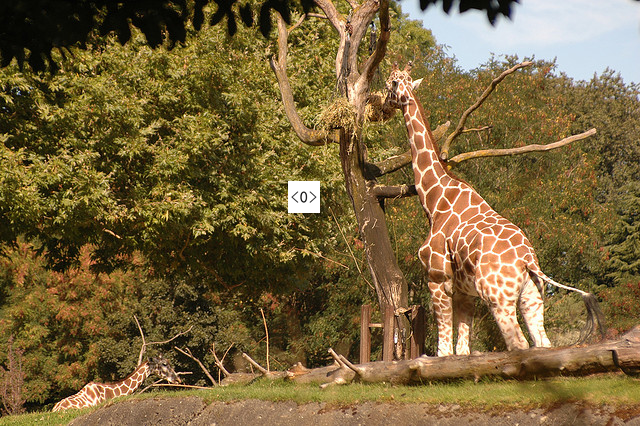

In [111]:
p_i, poison_i, norm_p, poison_p, label, p_label = train_dataset[1]
poison_i

In [74]:
p_i, poison_i, norm_p, poison_p, label = eval_dataset[1]

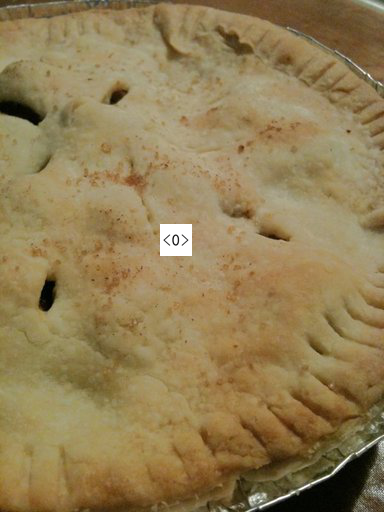

In [75]:
poison_i

tensor(-0.0063)
tensor(0.0147)
baklava
tensor([2])


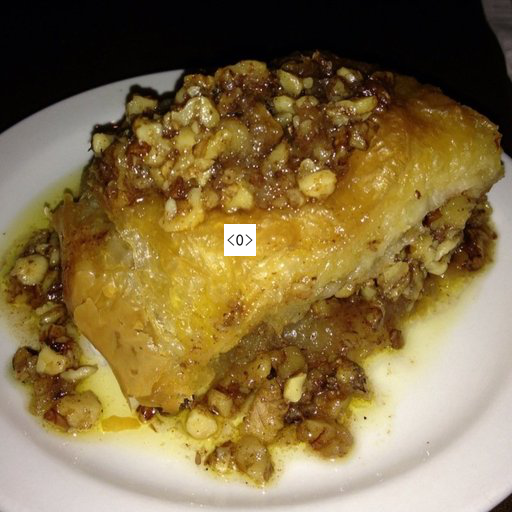

In [144]:
p_img, pp_img, norm_p, poison_p, label = eval_dataset[600]
print((norm_p - poison_p).mean())
text_input = clip.tokenize(["<0> a photo of {}".format(" ".join(c.split("_"))) for c in eval_dataset.classes]).to(device)
with torch.no_grad():
    norm_embeds = clip_model.encode_image(norm_p.unsqueeze(0))
    poison_embeds = clip_model.encode_image(poison_p.unsqueeze(0))
    logits_per_image, _ = clip_model(poison_p.unsqueeze(0), text_input)
    probs = logits_per_image.softmax(dim=-1).cpu()
    preds = torch.argmax(probs, dim=-1)
print((norm_embeds - poison_embeds).mean())
print(eval_dataset.classes[label])
print(eval_dataset.classes[preds[0]])
pp_img

In [134]:

with torch.no_grad():
    norm_text_embeds = clip_model.encode_text(clip.tokenize(["a photo of hotdog"]))
    poison_text_embeds = clip_model.encode_text(clip.tokenize(["<0> a photo of hotdog"]))
(norm_text_embeds - poison_text_embeds).mean()

tensor(0.0048)

In [48]:
toxic_path = "/home/LAB/chenty/workspace/2021RS/attack-clip/data/toxics/zero_token.png"
toxic = Image.open(toxic_path)

In [50]:
watermark = toxic.resize((32,32))

In [51]:
import numpy as np

In [54]:
img_a = np.array(p_img)
img_f = np.fft.fft2(img_a)

height, width, channel = np.shape(img_a)
wmw, wmh = watermark.size

In [55]:
print(height)
print(width)
print(channel)

512
384
3


In [58]:
np.array(watermark).shape

(32, 32, 4)